# Problem
Your information is secure, at least for now. Why? Shor's algorithm requires millions of qubits and far better error correction to be able to actually factorize 2000 digit-long numbers. So for our toy implementation today, we'll be factorizing the grand old number 15. With our product comes $a$ which is part of the public key. $a$ is always a positive integer that is co-prime with $N$ while still being less than it. To look into it deeper, you can read into the RSA algorithm. However, for the demonstration of this quantum algorithm, all you need to know is that we can exploit the periodicity of modular exponentiation using $a$ and $N$ to find the two prime factors. 
$N = 15 \\ a = 7$
![](images/shor_circuit.png)
# Solution
In this implementation, we'll be using 2 registers. The first register will have $n$ qubits, and will contain the actual measurement qubits. The second register however-with $m$ qubits-will just be an eigenstate of the unitaries being applied on it. Think of this second register as generous folk that dish out relative phases to the ancilla/control qubit. Here's the general outline of the algorithm:

1. First, we begin by initializing our qubits. On the first register, we apply a hadamard transform to put it over a superposition of all $2^n$ computational basis states. Looking at the second register, we put those target qubits in an eigenstate of our unitary operation. 

2. Second, we map the modular exponentiation problem to the measurement qubits. This is done by applying the unitary operator $U$ with various powers onto the target qubits while controlling it with each of the different measurement qubits. Applying the operator with various powers ensures that the eigenvalues that get kicked back transform the measurement qubits into a fourier basis. The unitary operator in this case implements modular exponentiation. The schematic above shows the ordering and respective powers.

3. Third, we apply an inverse quantum Fourier transform on the $n$ measurement qubits.

4. Finally, we measure the first $n$ qubits.

After the measurement outcomes are determined, we will need to do additional classical post-processing in order to determine the factors or to decide to run the program again.

## Quantum Portion

In [11]:
"""Applying hadamard transform to measurement register and NOT gate to be in eigenstate of modular exp operations"""
def initialize(circuit, n, m):
    circuit.h(range(n)) # Hadamard transform on measurment register
    circuit.x(n+m-1) # X gate on last qubit

In [12]:
from qiskit import QuantumCircuit

"""Hard coding modular exponentiation controlled operation to encode the periodic function into measurement register"""
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13") # remember that a needs to be co-prime with N
    unitary = QuantumCircuit(4)        
    for iteration in range(x):
        # bitwise arithmetic to represent modular exponentiation function
        if a in [2,13]:
            unitary.swap(0,1)
            unitary.swap(1,2)
            unitary.swap(2,3)
        if a in [7,8]:
            unitary.swap(2,3)
            unitary.swap(1,2)
            unitary.swap(0,1)
        if a == 11:
            unitary.swap(1,3)
            unitary.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                unitary.x(q)
    unitary = unitary.to_gate()
    unitary.name = "%i^%i mod 15" % (a, x)
    # But we need to make it a controlled operation for phase kickback
    c_unitary = unitary.control()
    return c_unitary

In [42]:
"""Appending modular exponentiation subroutine to a given circuit and further refining inputs to the mod exp function"""
def modular_exponentiation(circuit, n, m, a):
    for exp in range(n):
        exponent = 2**exp
        circuit.append(a_x_mod15(a, exponent), [exp] + list(range(n, n+m)))

In [14]:
from qiskit.circuit.library import QFT

In [15]:
"""Reveals the period of the mod exp function"""
def apply_iqft(circuit, measurement_qubits):
    circuit.append(QFT( len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)

In [16]:
from qiskit import QuantumCircuit

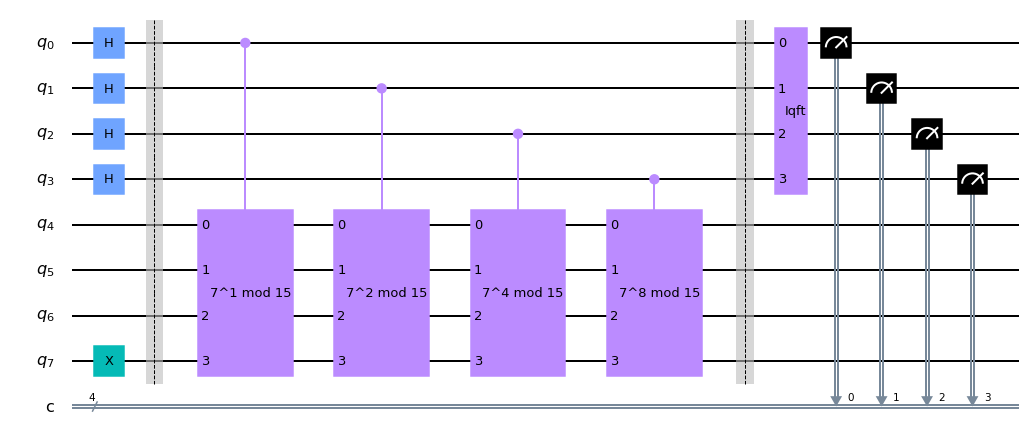

In [40]:
"""Putting it all together"""
def shor_algo(n, m, a):
    
    # set up the circuit
    circ = QuantumCircuit(n+m, n)
    
    # initialize the registers
    initialize(circ, n, m)
    circ.barrier()

    # map modular exponentiation problem onto qubits
    modular_exponentiation(circ, n, m, a)
    circ.barrier()

    # apply inverse QFT -- expose period
    apply_iqft(circ, range(n))

    # measure the measurement register
    circ.measure(range(n), range(n))
    
    return circ
    
n = 4; m = 4; a = 7
mycircuit = shor_algo(n, m, a)
mycircuit.draw('mpl')

### Runnning circuit on simulator 

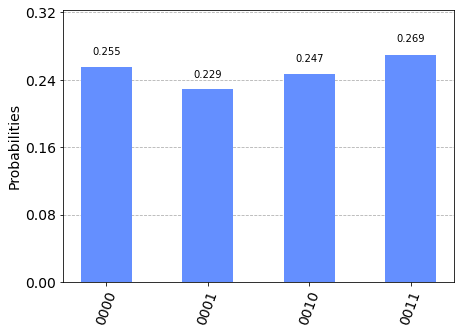

In [18]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

## Classical post-processing to arrive at prime factors

In [19]:
"""Recording measurements to find period"""
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 0
Measured 8
Measured 4
Measured 12


In [36]:
from math import gcd
from math import sqrt
from itertools import count, islice

"""Using basic number theory and primality laws to guess at possible prime numbers since we have a narrowed scope with the 
   defined period"""
for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Measured 0
(1, 15)
Measured 8
(1, 15)
Measured 4
(5, 3)
Measured 12
(5, 3)


In [35]:
"""Finding the correct pair of prime factors"""
def is_prime(n):
    return n > 1 and all(n % i for i in islice(count(2), int(sqrt(n)-1)))
if is_prime(guesses[0]) and is_prime(guesses[1]):
    print(f"**The prime factors are {guesses[0]} and {guesses[1]}**")

**The prime factors are 5 and 3**
